In [1]:
import numpy as np
import pandas as pd
import itertools

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Task 4

In [2]:
data_4 = np.array((49,58,75,110,112,132,151,276,281,362))

In [3]:
m0 = 200
round(stats.wilcoxon(data_4 - m0)[1],4)

0.2845

## Task 5

In [4]:
data1_5 = np.array((22,22,15,13,19,19,18,20,21,13,13,15))
data2_5 = np.array((17,18,18,15,12,4,14,15,10))

In [5]:
round(stats.mannwhitneyu(data1_5, data2_5)[1],4)

0.029

## Task 6

In [6]:
data_6 = pd.read_csv('challenger.txt', sep='\t')

In [7]:
data_6.head()

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


In [8]:
data_6.describe()

,Temperature,Incident
count,23.000000,23.000000
mean,20.860870,0.304348
std,3.919501,0.470472
min,11.700000,0.000000
25%,19.400000,0.000000
50%,21.100000,0.000000
75%,23.900000,1.000000
max,27.200000,1.000000


In [11]:
data_w6 = data_6[data_6.Incident==1].Temperature
data_wo6 = data_6[data_6.Incident==0].Temperature

In [12]:
data_w6

1     21.1
8     13.9
9     17.2
10    21.1
13    11.7
20    23.9
22    14.4
Name: Temperature, dtype: float64

In [13]:
round(float(data_w6.shape[0])/float(data_6.shape[0]),6) # just a check

0.304348

In [14]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [15]:
np.random.seed(0)

data_w6_scores = map(np.mean, get_bootstrap_samples(np.array(data_w6), 1000))
data_wo6_scores = map(np.mean, get_bootstrap_samples(np.array(data_wo6), 1000))

In [16]:
len(data_w6_scores)

1000

In [17]:
data_w6_scores[:20]

[19.12857142857143,
 18.642857142857142,
 15.228571428571428,
 18.5,
 19.985714285714288,
 19.514285714285712,
 16.114285714285717,
 17.685714285714287,
 18.257142857142856,
 15.557142857142859,
 16.100000000000001,
 18.642857142857142,
 14.528571428571428,
 14.771428571428572,
 20.400000000000002,
 18.88571428571429,
 18.014285714285716,
 19.75714285714286,
 18.87142857142857,
 17.599999999999998]

In [18]:
data_wo6_scores[:20]

[21.762499999999999,
 22.40625,
 21.78125,
 22.106249999999999,
 22.681249999999999,
 22.912500000000001,
 22.100000000000001,
 21.618749999999999,
 21.574999999999999,
 22.15625,
 21.03125,
 23.068750000000001,
 21.587499999999999,
 22.462499999999999,
 21.831250000000001,
 21.75,
 22.143750000000001,
 22.3125,
 22.043749999999999,
 21.849999999999998]

In [19]:
diff_data = np.array(data_w6_scores)-np.array(data_wo6_scores)

In [20]:
diff_data.shape

(1000L,)

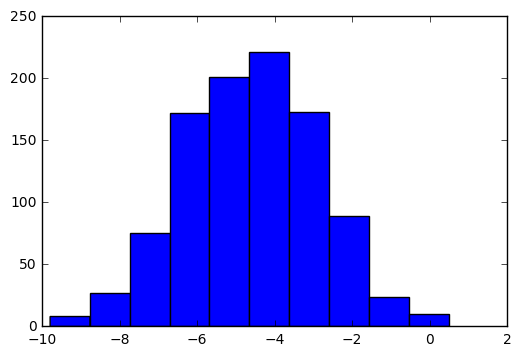

In [21]:
pylab.hist(diff_data)
pylab.show()

In [23]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [24]:
stat_intervals(diff_data, 0.05)

array([-8.06457589, -1.45040179])

In [26]:
ans = stat_intervals(diff_data, 0.05)
round(ans[1],4)

-1.4504

## Task 7

In [49]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [50]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [51]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [52]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [54]:
np.random.seed(0)
round(permutation_test(np.array(data_w6), np.array(data_wo6), max_permutations = 10000),4)

0.0057